In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2

In [3]:
from PIL import Image

In [4]:
# change this after the first time so we don't recreate things needlessly
FIRST_TIME_RUNNING_THIS_NOTEBOOK = True

## Got examples of something you like?

Maybe you have a graphic filter that does something cool, and want to do what it does.

Maybe you have deteriorated copies and only a few high-quality originals.

### CLAHE

Contrast-Limited Adaptive Histogram Equalization

Now that's an example cool thing to do to images.

OK, take an image (Thank you, Obsidian and Bethesda)...

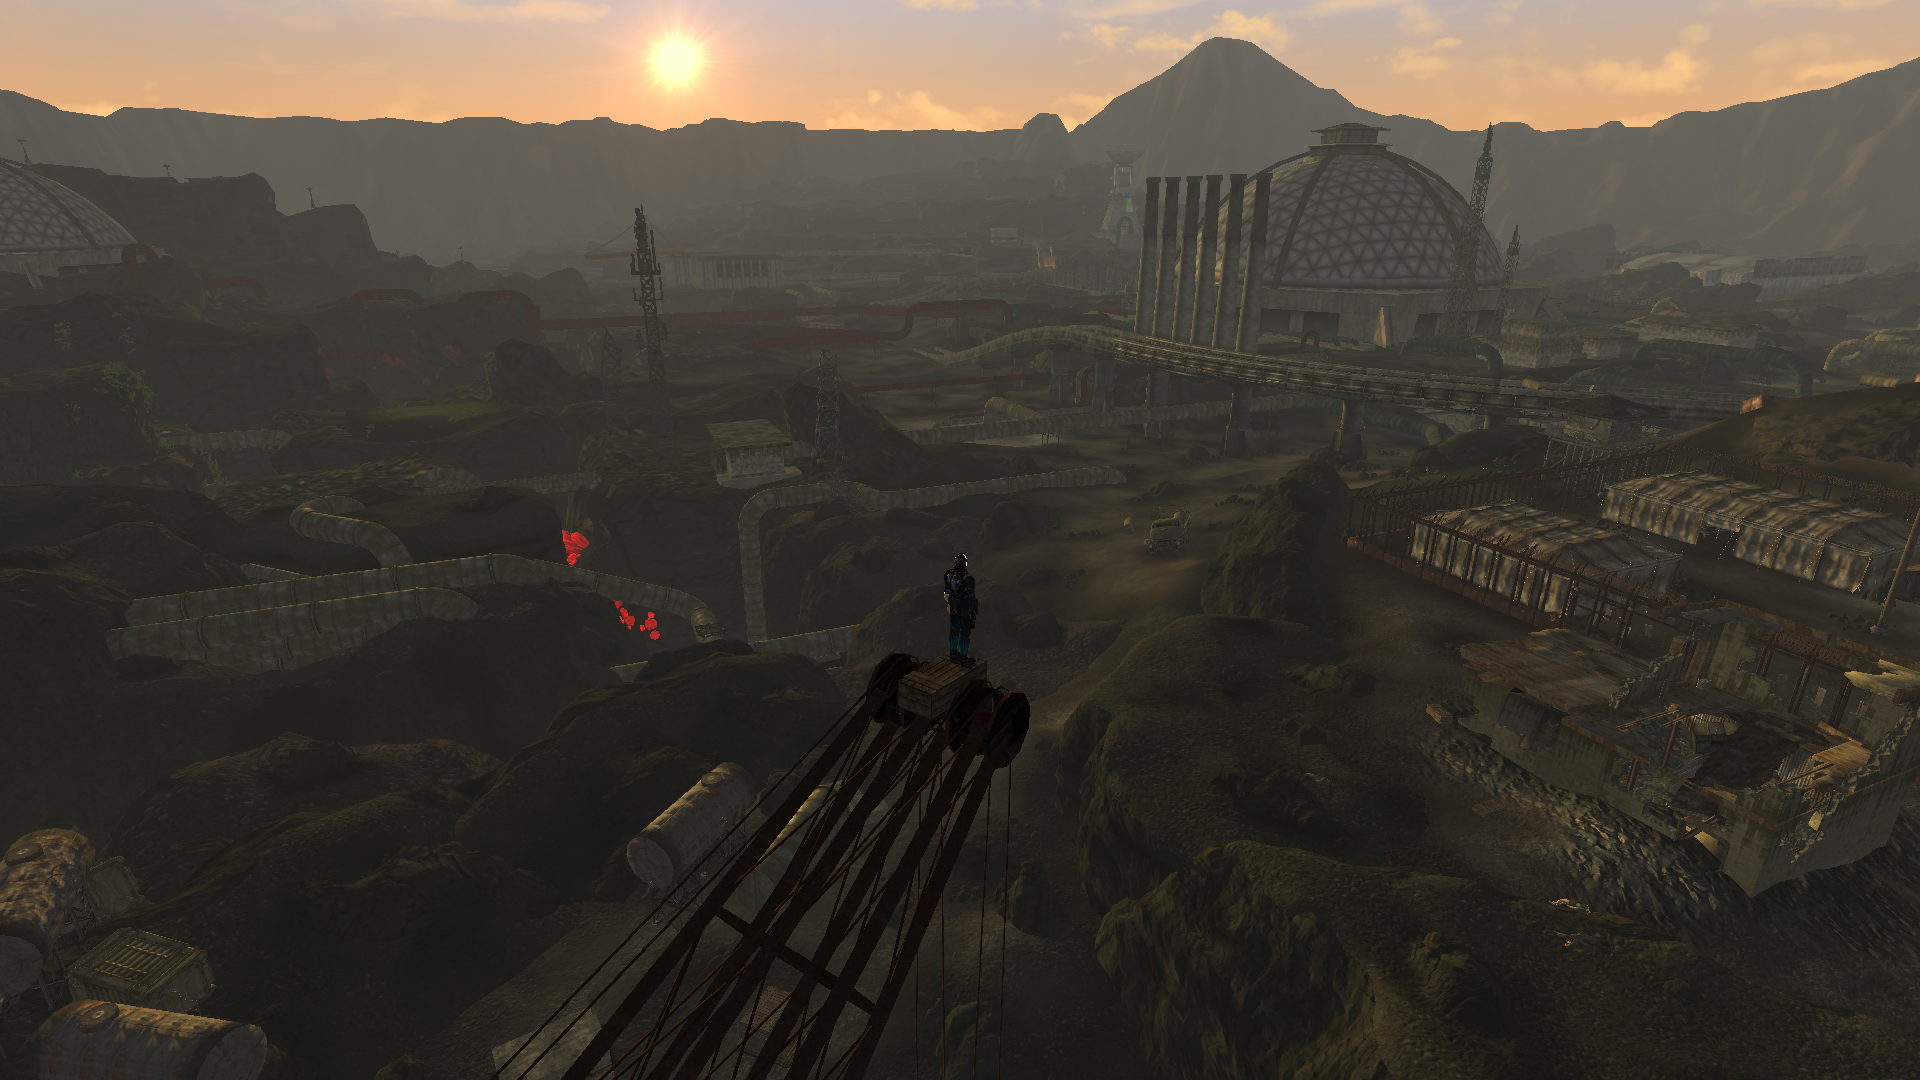

In [5]:
img = Image.open('Fallout NV Old World Blues screenshot.png') # in same folder as notebook
img # Image object, can render directly

Nope, **too good**.
"crappify" it - add "fog" gradient.

And let's have OpenCV load it as greyscale, since that is what CLAHE works with.

In [6]:
from PIL import Image,ImageDraw

In [7]:
def crappify_with_gradient(img):
    img = img.convert("RGBA") # needed?
    overlay = Image.new('RGBA', img.size, (0,0,0,0)) # needed. Draw replaces pixels, no bleding.
    draw = ImageDraw.Draw(overlay)
    alpha_min = 0
    alpha_max = 180
    for i in range(overlay.height): # white top
        alpha = int(alpha_max - i*(alpha_max-alpha_min)/overlay.height)
        draw.line((0,i,overlay.width,i), fill=(255,255,255,alpha))
    tmp = Image.alpha_composite(img, overlay)
    for i in range(overlay.height): # black bottom
        alpha = int(i*(alpha_max-alpha_min)/overlay.height + alpha_min)
        draw.line((0,i,overlay.width,i), fill=(0,0,0,alpha))
    return Image.alpha_composite(tmp, overlay)

In [8]:
if FIRST_TIME_RUNNING_THIS_NOTEBOOK:
    img = crappify_with_gradient(img)
    img.save('Fallout NV Old World Blues screenshot_crap1.png')

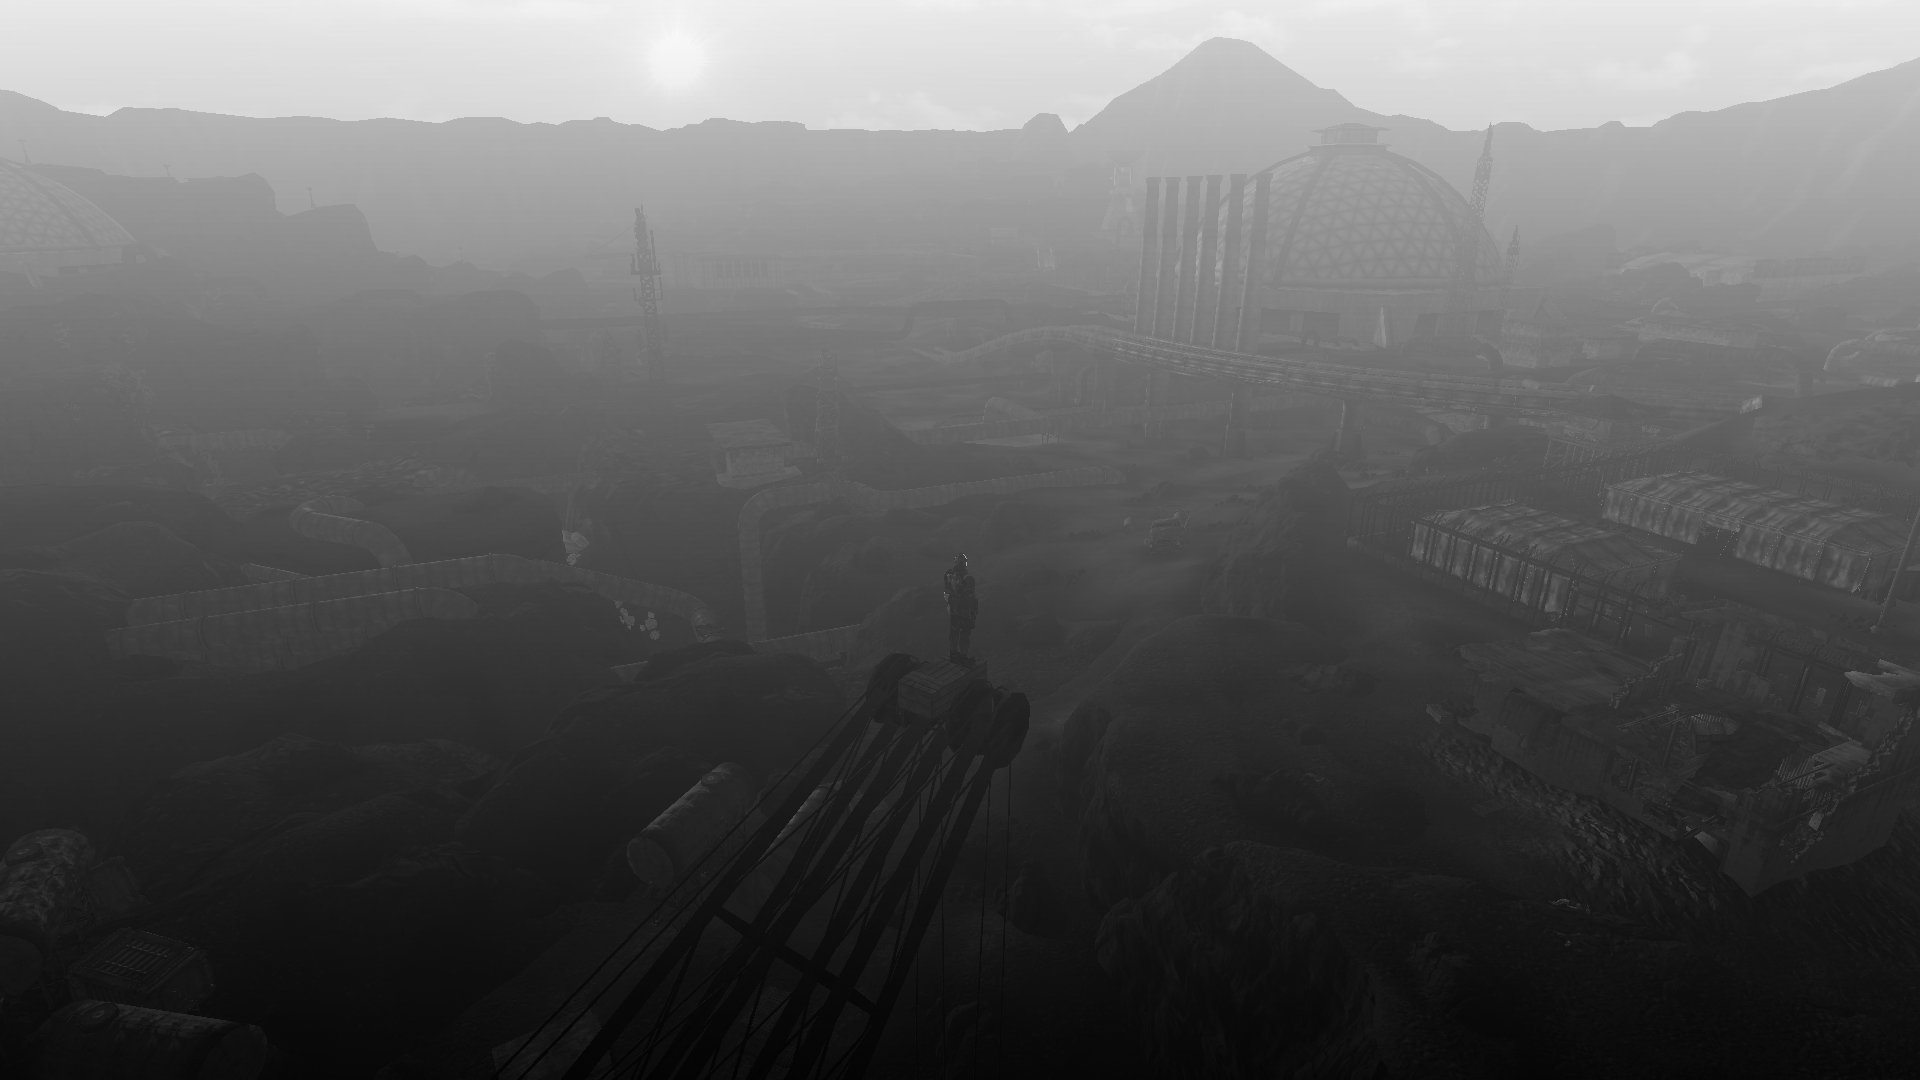

In [9]:
img = cv2.imread('Fallout NV Old World Blues screenshot_crap1.png',0)
Image.fromarray(img) # img is an array, must convert to see

Now there's a crappy detail visibility. **This** is what we'll be working with as input.

Imagine getting much detail from this? No amount of contrast or gamma sliding can fix this mess. You may tweak, but any feature visibility you get comes at the expense of making everything else too bright or too dark to see.

**Enter CLAHE**. It works with greyscale, so let's load it as such, with OpenCV:

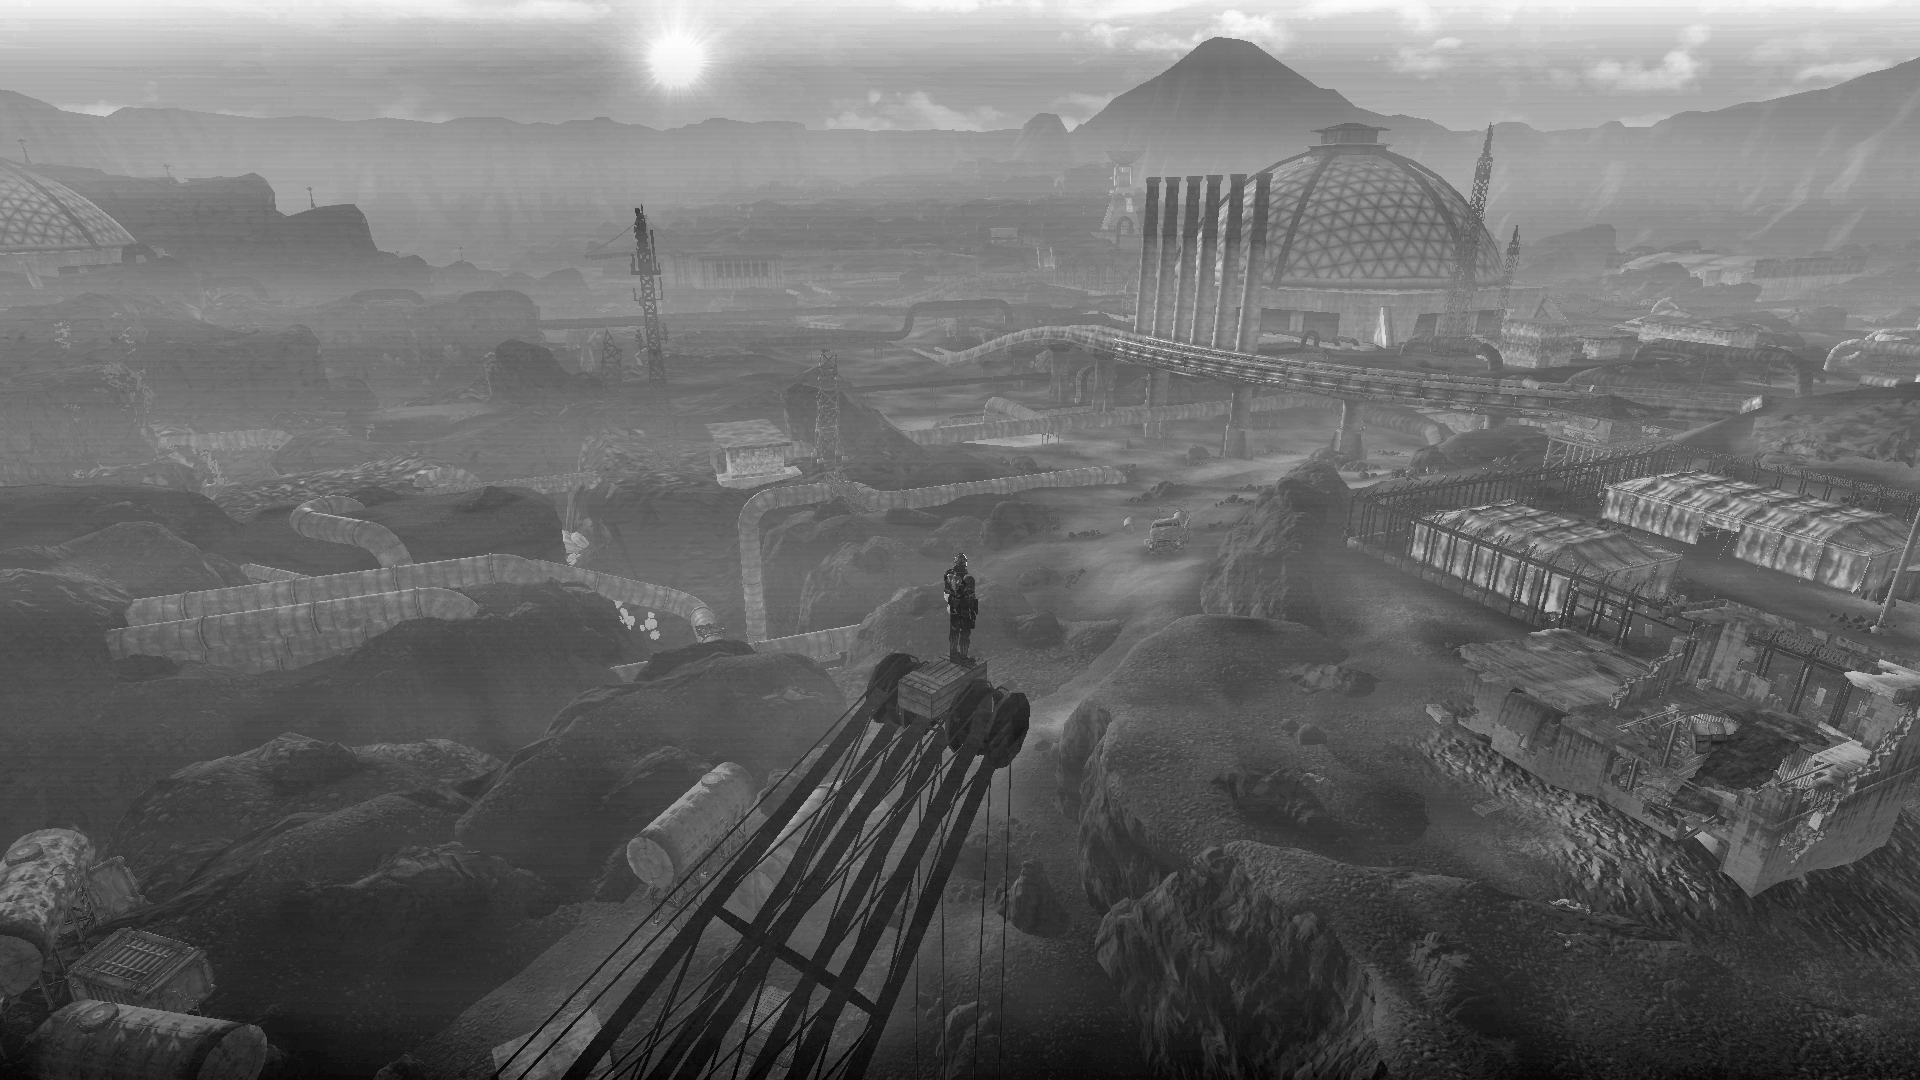

In [10]:
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
Image.fromarray(cl1) # display the data as image

And behold, **we can see things!** Rock textures! Clouds! And all that regardless of dark / bright areas!

What's with he horizontal waves? That's a [Moire pattern](https://en.wikipedia.org/wiki/Moir%C3%A9_pattern). Ignore it, this one comes from the undithered gradients we had crappified the input with.

Can a neural net learn to do that just from examples?

## Throw an AI at it

As the [Practical Deep Learning for Coders](https://course.fast.ai/videos/?lesson=7) course shows, it might do the trick.

In [11]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import numpy
from PIL import Image

### Create dataset images

We'll work with the pets dataset, since it will do O.K. Could add more later, too.  So, first, create the modified dataset with downscaled images and their converted counterparts:

In [12]:
petsPath = untar_data(URLs.PETS)
path_input = petsPath/'images'
path_clahe = petsPath/'..'/'clahe'
path_pre = path_clahe/'pre'
path_post = path_clahe/'post'

In [13]:
bs = 8
img_size = 128
arch = models.resnet18

In [14]:
def pil2opencv(pil_image):
    return cv2.cvtColor(numpy.array(pil_image), cv2.COLOR_RGB2GRAY) #COLOR_RGB2BGR

class clahefier(object):
    def __init__(self, path_pre, path_post, img_size=128, clipLimit=3.0, tileGridSize=(8,8)):
        self.path_pre = path_pre
        self.path_post = path_post
        path_pre.mkdir(parents=True, exist_ok=True)
        path_post.mkdir(parents=True, exist_ok=True)
        self.img_size = img_size
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        #self.clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize) # TypeError: can't pickle cv2.CLAHE objects

    def __call__(self, path_in, i):
        pil_img = PIL.Image.open(path_in)
        #targ_sz = resize_to(pil_img, self.img_size, use_min=True)
        # the resize below does not preserve aspect ratio, but who cares
        pil_img = pil_img.resize((self.img_size, self.img_size), resample=PIL.Image.BILINEAR).convert('RGB')
        pil_img.save(self.path_pre/(path_in.stem+'.png')) # save downscaled
        ocv_img = pil2opencv(pil_img) # convert to opencv format
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        ocv_img = clahe.apply(ocv_img)
        Image.fromarray(ocv_img).save(self.path_post/(path_in.stem+'.png')) # save clahe'd
#         cv2.imwrite(self.path_post/(path_in.stem+'.png'), ocv_img) # save clahe'd

In [15]:
if FIRST_TIME_RUNNING_THIS_NOTEBOOK:
    il = ImageList.from_folder(path_input)
    il.items[0]

In [16]:
if FIRST_TIME_RUNNING_THIS_NOTEBOOK:
    parallel(clahefier(path_pre, path_post, img_size=img_size), il.items, max_workers=1)

### Pre-train generator

... and now we have our examples. Load them:

In [17]:
def get_data(bs,size,src):
    data = (src.label_from_func(lambda x: path_post/x.name)
           .databunch(bs=bs)) # no transforms, even normalization - the pixels must stay at their places and values
    data.c = 3
    return data

data_gen = get_data(bs, img_size, ImageImageList.from_folder(path_pre).split_by_rand_pct(0.1, seed=42))

So what do our examples look like? Square images as the inputs and their greyscale CLAHE'd counterparts as the expected values:

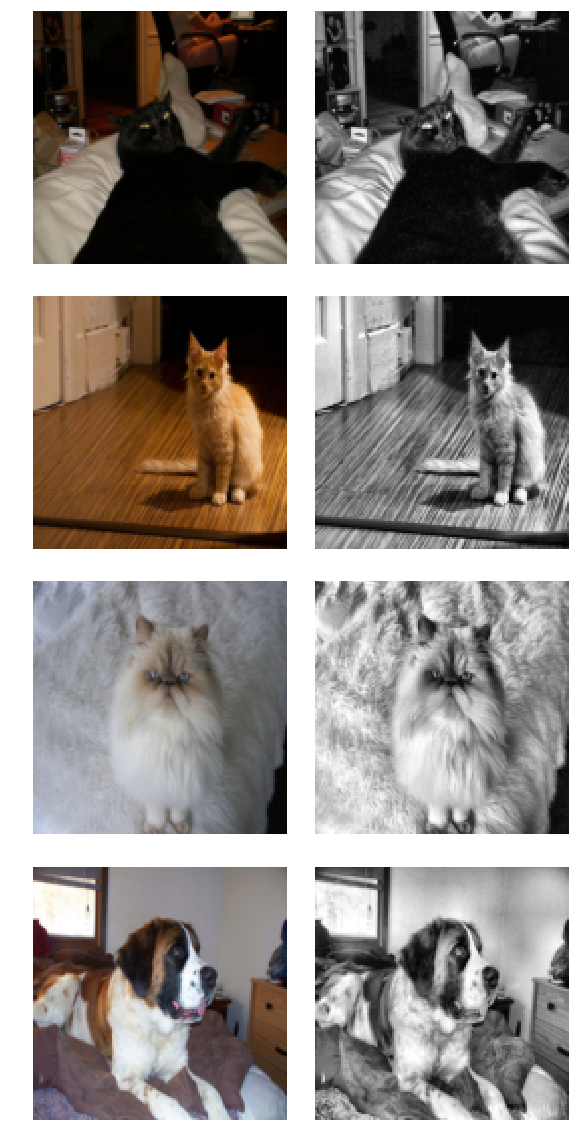

In [18]:
data_gen.show_batch(4)

Train the encoder part:

In [19]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=1e-3, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=(-3.,3.), loss_func=MSELossFlat())
learn_gen = create_gen_learner()

**if you've already trained**, load the weights

In [22]:
if not FIRST_TIME_RUNNING_THIS_NOTEBOOK:
    learn_gen.load('clahe_generator_01')

**else pre-train** and save

In [21]:
if FIRST_TIME_RUNNING_THIS_NOTEBOOK:
    learn_gen.fit_one_cycle(2, pct_start=0.8)
    learn_gen.save('clahe_generator_01')

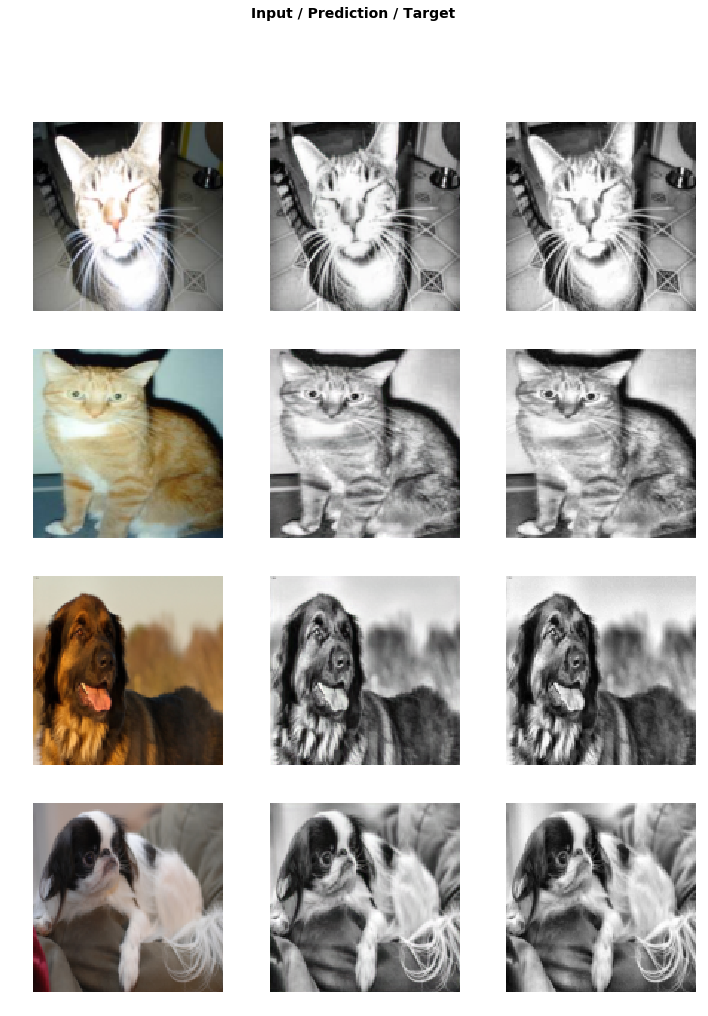

In [23]:
learn_gen.show_results(rows=4)

### ~~Train discriminator~~  What? We're done already?

Looks like we can forget fine-tuning and adversarial networks, the task is complete!

CLAHE is by no means simple, but using a resnet-18 for it is like using a flamethrower to kill a mosquito.

In [24]:
learn_gen.export("export_clahe1")

What next?

Simpler model, better effects (e.g. preserve color)